In [9]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.animation as animation
import cv2

La función preprocess(img) recorta una region de interes en la imagen y la convierte a escala de grises, normalizando los valores de los pixeles.

In [6]:
def preprocess(img):
    img = img[:84, 6:90] 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

La clase ImageEnv ayuda a procesar las imágenes y manejar el estado en un juego. Permite hacer ajustes a las imágenes y agrupar varias imágenes en una sola para tener una mejor representación del estado del juego.

In [7]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
    
    def reset(self):
        s, info = self.env.reset()
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        s = preprocess(s)
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        s = preprocess(s)

        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

Se crea un entorno de juego y se procesa la primera observación obtenida. Luego se muestran las primeras cuatro imágenes del estado del juego.

The shape of an observation:  (4, 84, 84)


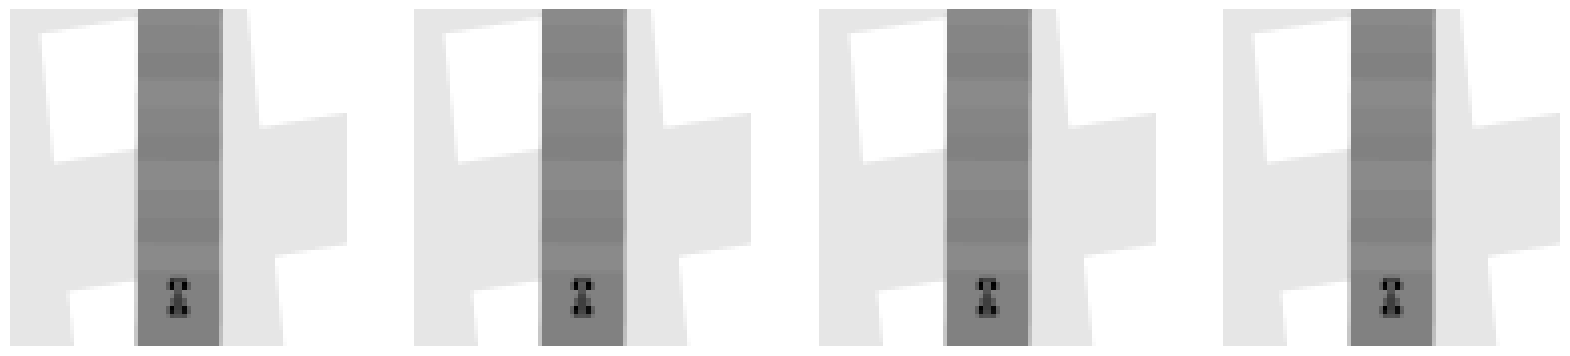

In [8]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

Se ejecutan cuatro acciones "acelerar" en el entorno del juego y se obtienen las nuevas observaciones. Luego se muestran las imágenes correspondientes a las nuevas observaciones en un gráfico de 4 columnas.

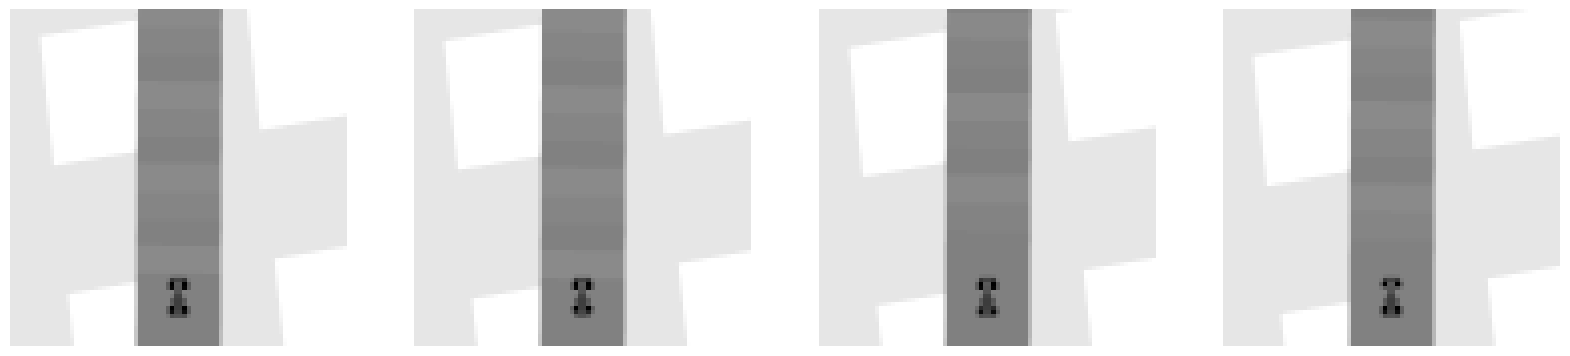

In [10]:
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # acelerar =3

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()